# 第三章·第1节　神经网络实现：拟合

以下是本次项目需要使用的所有依赖项：

- pytorch
- matplotlib

你还需要额外安装以下应用程序：

- ImageMagick

## 数据的准备

1. 导入需要的第三方Python包

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime

2. 生成一定规模的数据集

In [2]:
# 在[-1, 1]之间等差地产生100个数据点，并将这些数据升维为二维矩阵
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
# 这些只是生成了横坐标，我们还要生成纵坐标，才能组成平面上的点。
# 生成一个近似遵守 y = x ^ 2 + C 的数据点，C作为随机噪点对标准数据产生干扰
y = x.pow(2) + 0.2 * torch.rand(x.size())

## 定义神经网络模型

In [3]:
class Net(torch.nn.Module):
    ''' # 自定义神经网络模型 #

        torch.nn.Module是神经网络模型的核心类
    '''

    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        ''' # ★构造函数 #

            构造函数定义了搭建每一层神经网络所需要的必须参数
            
            input_nodes: 输入层节点数
            hidden_nodes: 隐含层节点数
            output_nodes: 输出层结点数
        '''
        # 将torch.nn.Module继承到Net中，同时初始化torch.nn.Module
        super(Net, self).__init__()
        # 这是神经网络中的一层，每一层都可以单独视作一个模型，拥有输入、隐含、输出3层。
        # 每2层神经元之间的联结强度都是线性关系，按照敏感程度线性地激发/抑制
        self.hidden = torch.nn.Linear(input_nodes, hidden_nodes)
        self.predict = torch.nn.Linear(hidden_nodes, output_nodes)

    def forward(self, x):
        ''' #前向传递过程描述 #

            在这个Demo中，我们用于解决拟合问题的神经网络是一个前馈网络。
            前馈网络必须定义前向传播的方法
            
            x: 前一层输入的激发度
        '''
        # 用Relu激励函数对激发值进行压缩
        x = torch.relu(self.hidden(x))
        # 继续将神经刺激传递给下一层，激励压缩在下一层输入时发生
        x = self.predict(x)
        # 返回神经冲动
        return x

## 构建模型

In [4]:
# Demo所用的神经网络模型为单隐含层模型，
# 1个输入结点，10个隐含节点，1个输出结点
net = Net(1, 10, 1)
# 查看模型详情
net

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)

## 构建优化器

*SGD*（Stochastic Gradient Descent）是*梯度下降法*的一种。我们要通过这个内置优化器优化神经网络的各种参数，就必须传入参数并指定优化器的*学习率*。

*学习率*越高意味着神经网络的训练速度越高，但过高的学习率将导致参数的过拟合，反而降低了神经网络的准确度（钻牛角尖到死胡同里了）。所以，切忌将学习率调的太高，本次Demo将采用50%的学习率。注意学习率是一个比率（写作小数形式），取值在0～1之间。

In [5]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.25)

*MSE*（均方误差）是描述估计值与真实值差距的一种方法，我们通过它对模型进行调校，使误差最小化、拟合效果最好。

`loss_func`是一个函数对象，按顺序接受2个参数：预测值和准确值。

In [6]:
loss_func = torch.nn.MSELoss()

## 开始训练！

1. 未训练时的初始模型

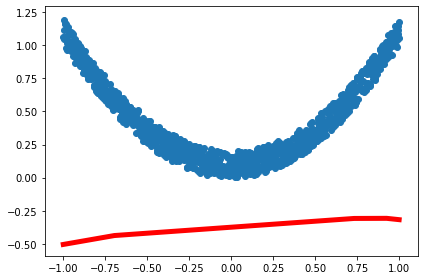

In [7]:
import sys
from matplotlib.animation import FuncAnimation

(figure, axes) = plt.subplots()
figure.set_tight_layout(True)
screen_dpi = figure.get_dpi()

axes.scatter(x.data.numpy(), y.data.numpy())
line = axes.plot(x.data.numpy(), net(x).data.numpy(), 'r-', lw=5)[0]

2. 定义训练步骤

In [8]:
def curve_fitting(index):
    # 输入数据并给出预测值
    prediction = net(x)
    line.set_ydata(prediction.data.numpy())
    # 计算预测损失
    loss = loss_func(prediction, y)
    label = 'Training times: {}\nLoss: {}'.format(index, loss)
    axes.set_xlabel(label)

    # 下面的3步就是真正的优化步骤了：
    # 1. 清空优化器当中的梯度信息，将它们设置为0，为下一次优化做准备
    optimizer.zero_grad()
    # 2. 反向传播，为上一层网络计算梯度
    loss.backward()
    # 3. 以指定的学习率对梯度进行优化
    optimizer.step()
    
    return (line, axes)

3. 训练并生成动态图

In [9]:
# 共训练200次
start_time = datetime.datetime.now()
gif = FuncAnimation(
    figure,
    curve_fitting,
    frames=range(1, 200),
    interval=1
)
gif.save('../images/regression.gif', dpi=screen_dpi, writer='imagemagick')
end_time = datetime.datetime.now()
'训练记录导出成功！累计用时：{}秒'.format(end_time - start_time)

'训练记录导出成功！累计用时：0:00:52.432877秒'